## Import Libraries

In [1]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
import scipy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max
import random 
from tensorflow.keras.utils import plot_model
import visualkeras
import matplotlib.pyplot as plt

## Data Preprocessing

In [28]:
input_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset/')
output_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.2))

Copying files: 7324 files [00:10, 711.36 files/s]


In [29]:
train_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/train/')
val_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/val/')

In [30]:
def image_generator(train_parent_directory, val_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size=(224,224),
                                                        batch_size=140,
                                                        class_mode='categorical',
                                                        subset='training')
    
    val_generator = val_datagen.flow_from_directory(val_parent_directory,
                                                     target_size=(224,224),
                                                      batch_size=37,
                                                      class_mode='categorical')
    
    return train_generator, val_generator

In [31]:
train_generator, val_generator = image_generator(train_dir, val_dir)

Found 5859 images belonging to 2 classes.
Found 1465 images belonging to 2 classes.


## Data Exploration

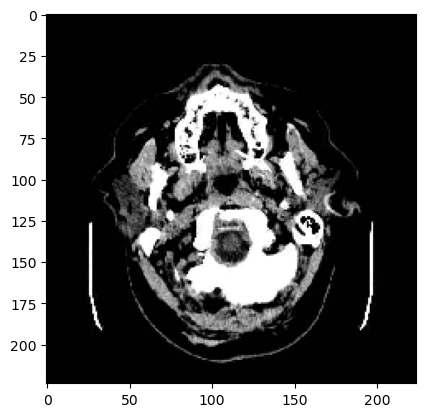

In [6]:
images, labels = next(train_generator)
image = images[0]

plt.imshow(image)
plt.show()

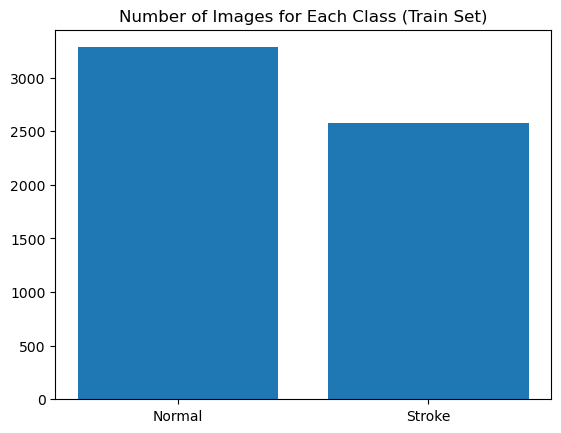

In [7]:
class_counts = train_generator.classes

img_list=[]

for i in class_counts:
    if i == 0:
        img_list.append('Normal')
    else:
        img_list.append('Stroke')
        
counts = dict()
for val in img_list:
    counts[val] = counts.get(val, 0) + 1

plt.bar(counts.keys(), counts.values())
plt.title('Number of Images for Each Class (Train Set)')
plt.show()

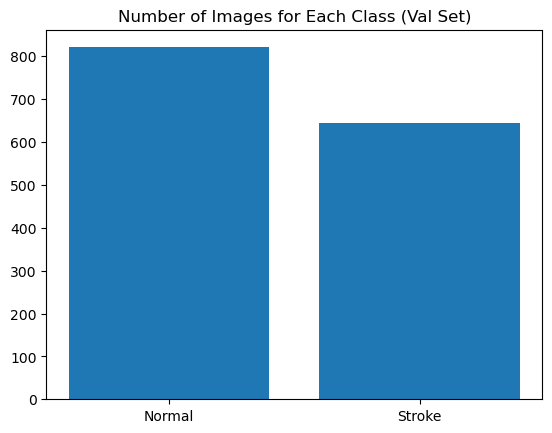

In [8]:
class_counts = val_generator.classes

img_list=[]

for i in class_counts:
    if i == 0:
        img_list.append('Normal')
    else:
        img_list.append('Stroke')
        
counts = dict()
for val in img_list:
    counts[val] = counts.get(val, 0) + 1

plt.bar(counts.keys(), counts.values())
plt.title('Number of Images for Each Class (Val Set)')
plt.show()

## Modelling

### Create Model

In [147]:
tfd = tfp.distributions
tfpl = tfp.layers

In [148]:
def create_bayesian_model(input_shape=(224, 224, 3), num_classes=2, divergence_fn=None):
    if divergence_fn is None:
        def divergence_fn(q, p, _):
            return tfp.distributions.kl_divergence(q, p) / 8569

    model = Sequential([
        tfpl.Convolution2DReparameterization(
            input_shape=input_shape, 
            filters=4, 
            kernel_size=8, 
            activation='relu',
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        tfpl.DenseReparameterization(
            units=tfpl.OneHotCategorical.params_size(num_classes), 
            activation=None,
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        tfpl.OneHotCategorical(num_classes)
    ])

    return model

In [149]:
model_bayes = create_bayesian_model(input_shape=(224, 224, 3), num_classes=2)

In [150]:
model_bayes.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_3  (None, 217, 217, 4)      1544      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 108, 108, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 51, 64)        18496     
                                                      

In [151]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

### Train and Validate Model

In [152]:
history_bayes = model_bayes.fit(
      train_generator,
      validation_data=val_generator,
      epochs=500,
      verbose=1)

Epoch 1/500
42/42 [==============================] - 139s 3s/step - loss: 1.1751 - accuracy: 0.5533 - val_loss: 1.1196 - val_accuracy: 0.5577
Epoch 2/500
42/42 [==============================] - 136s 3s/step - loss: 1.0613 - accuracy: 0.6254 - val_loss: 1.0007 - val_accuracy: 0.6662
Epoch 3/500
42/42 [==============================] - 136s 3s/step - loss: 0.9549 - accuracy: 0.6970 - val_loss: 0.9030 - val_accuracy: 0.7413
Epoch 4/500
42/42 [==============================] - 136s 3s/step - loss: 0.8774 - accuracy: 0.7617 - val_loss: 0.8505 - val_accuracy: 0.7911
Epoch 5/500
42/42 [==============================] - 137s 3s/step - loss: 0.8286 - accuracy: 0.7952 - val_loss: 0.7879 - val_accuracy: 0.8184
Epoch 6/500
42/42 [==============================] - 136s 3s/step - loss: 0.7403 - accuracy: 0.8546 - val_loss: 0.7112 - val_accuracy: 0.8717
Epoch 7/500
42/42 [==============================] - 136s 3s/step - loss: 0.6842 - accuracy: 0.8882 - val_loss: 0.6789 - val_accuracy: 0.8867
Epoch 

42/42 [==============================] - 137s 3s/step - loss: 0.5110 - accuracy: 0.9986 - val_loss: 0.5159 - val_accuracy: 0.9973
Epoch 59/500
42/42 [==============================] - 137s 3s/step - loss: 0.5112 - accuracy: 0.9988 - val_loss: 0.5189 - val_accuracy: 0.9973
Epoch 60/500
42/42 [==============================] - 136s 3s/step - loss: 0.5100 - accuracy: 0.9988 - val_loss: 0.5231 - val_accuracy: 0.9966
Epoch 61/500
42/42 [==============================] - 136s 3s/step - loss: 0.5092 - accuracy: 0.9993 - val_loss: 0.5206 - val_accuracy: 0.9959
Epoch 62/500
42/42 [==============================] - 137s 3s/step - loss: 0.5089 - accuracy: 0.9990 - val_loss: 0.5188 - val_accuracy: 0.9959
Epoch 63/500
42/42 [==============================] - 137s 3s/step - loss: 0.5084 - accuracy: 0.9990 - val_loss: 0.5170 - val_accuracy: 0.9980
Epoch 64/500
42/42 [==============================] - 136s 3s/step - loss: 0.5075 - accuracy: 0.9997 - val_loss: 0.5144 - val_accuracy: 0.9973
Epoch 65/500

42/42 [==============================] - 139s 3s/step - loss: 0.4946 - accuracy: 0.9852 - val_loss: 0.4876 - val_accuracy: 0.9925
Epoch 116/500
42/42 [==============================] - 136s 3s/step - loss: 0.4846 - accuracy: 0.9913 - val_loss: 0.4860 - val_accuracy: 0.9939
Epoch 117/500
42/42 [==============================] - 137s 3s/step - loss: 0.4814 - accuracy: 0.9942 - val_loss: 0.4758 - val_accuracy: 0.9939
Epoch 118/500
42/42 [==============================] - 136s 3s/step - loss: 0.4783 - accuracy: 0.9962 - val_loss: 0.4852 - val_accuracy: 0.9966
Epoch 119/500
42/42 [==============================] - 136s 3s/step - loss: 0.4733 - accuracy: 0.9983 - val_loss: 0.4786 - val_accuracy: 0.9980
Epoch 120/500
42/42 [==============================] - 136s 3s/step - loss: 0.4726 - accuracy: 0.9988 - val_loss: 0.4776 - val_accuracy: 0.9973
Epoch 121/500
42/42 [==============================] - 136s 3s/step - loss: 0.4715 - accuracy: 0.9986 - val_loss: 0.4830 - val_accuracy: 0.9980
Epoch 

Epoch 172/500
42/42 [==============================] - 137s 3s/step - loss: 0.4351 - accuracy: 0.9998 - val_loss: 0.4538 - val_accuracy: 0.9973
Epoch 173/500
42/42 [==============================] - 136s 3s/step - loss: 0.4348 - accuracy: 1.0000 - val_loss: 0.4391 - val_accuracy: 0.9980
Epoch 174/500
42/42 [==============================] - 137s 3s/step - loss: 0.4350 - accuracy: 0.9988 - val_loss: 0.4372 - val_accuracy: 0.9986
Epoch 175/500
42/42 [==============================] - 137s 3s/step - loss: 0.4338 - accuracy: 0.9985 - val_loss: 0.4415 - val_accuracy: 0.9973
Epoch 176/500
42/42 [==============================] - 137s 3s/step - loss: 0.4326 - accuracy: 0.9993 - val_loss: 0.4465 - val_accuracy: 0.9980
Epoch 177/500
42/42 [==============================] - 136s 3s/step - loss: 0.4325 - accuracy: 0.9995 - val_loss: 0.4453 - val_accuracy: 0.9973
Epoch 178/500
42/42 [==============================] - 136s 3s/step - loss: 0.4313 - accuracy: 0.9995 - val_loss: 0.4493 - val_accuracy:

Epoch 229/500
42/42 [==============================] - 139s 3s/step - loss: 0.3955 - accuracy: 1.0000 - val_loss: 0.4018 - val_accuracy: 0.9993
Epoch 230/500
42/42 [==============================] - 139s 3s/step - loss: 0.3950 - accuracy: 0.9995 - val_loss: 0.4039 - val_accuracy: 0.9980
Epoch 231/500
42/42 [==============================] - 142s 3s/step - loss: 0.3940 - accuracy: 0.9998 - val_loss: 0.4018 - val_accuracy: 0.9986
Epoch 232/500
42/42 [==============================] - 141s 3s/step - loss: 0.3932 - accuracy: 0.9998 - val_loss: 0.4033 - val_accuracy: 0.9980
Epoch 233/500
42/42 [==============================] - 140s 3s/step - loss: 0.3925 - accuracy: 1.0000 - val_loss: 0.3957 - val_accuracy: 0.9993
Epoch 234/500
42/42 [==============================] - 140s 3s/step - loss: 0.3920 - accuracy: 1.0000 - val_loss: 0.4021 - val_accuracy: 0.9973
Epoch 235/500
42/42 [==============================] - 142s 3s/step - loss: 0.3933 - accuracy: 0.9990 - val_loss: 0.4043 - val_accuracy:

Epoch 286/500
42/42 [==============================] - 137s 3s/step - loss: 0.3583 - accuracy: 1.0000 - val_loss: 0.3777 - val_accuracy: 0.9980
Epoch 287/500
42/42 [==============================] - 137s 3s/step - loss: 0.3577 - accuracy: 0.9998 - val_loss: 0.3677 - val_accuracy: 0.9973
Epoch 288/500
42/42 [==============================] - 137s 3s/step - loss: 0.3571 - accuracy: 0.9995 - val_loss: 0.3743 - val_accuracy: 0.9986
Epoch 289/500
42/42 [==============================] - 137s 3s/step - loss: 0.3563 - accuracy: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.9973
Epoch 290/500
42/42 [==============================] - 137s 3s/step - loss: 0.3556 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.9980
Epoch 291/500
42/42 [==============================] - 137s 3s/step - loss: 0.3550 - accuracy: 1.0000 - val_loss: 0.3709 - val_accuracy: 0.9980
Epoch 292/500
42/42 [==============================] - 137s 3s/step - loss: 0.3552 - accuracy: 0.9995 - val_loss: 0.3787 - val_accuracy:

Epoch 343/500
42/42 [==============================] - 138s 3s/step - loss: 0.3221 - accuracy: 0.9997 - val_loss: 0.3365 - val_accuracy: 0.9980
Epoch 344/500
42/42 [==============================] - 137s 3s/step - loss: 0.3213 - accuracy: 1.0000 - val_loss: 0.3345 - val_accuracy: 0.9980
Epoch 345/500
42/42 [==============================] - 137s 3s/step - loss: 0.3207 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.9993
Epoch 346/500
42/42 [==============================] - 137s 3s/step - loss: 0.3199 - accuracy: 1.0000 - val_loss: 0.3271 - val_accuracy: 0.9993
Epoch 347/500
42/42 [==============================] - 137s 3s/step - loss: 0.3204 - accuracy: 0.9991 - val_loss: 0.3275 - val_accuracy: 0.9980
Epoch 348/500
42/42 [==============================] - 137s 3s/step - loss: 0.3237 - accuracy: 0.9985 - val_loss: 0.3558 - val_accuracy: 0.9918
Epoch 349/500
42/42 [==============================] - 137s 3s/step - loss: 0.3226 - accuracy: 0.9978 - val_loss: 0.3280 - val_accuracy:

Epoch 400/500
42/42 [==============================] - 137s 3s/step - loss: 0.2891 - accuracy: 1.0000 - val_loss: 0.3063 - val_accuracy: 0.9980
Epoch 401/500
42/42 [==============================] - 136s 3s/step - loss: 0.2887 - accuracy: 0.9998 - val_loss: 0.3106 - val_accuracy: 0.9986
Epoch 402/500
42/42 [==============================] - 137s 3s/step - loss: 0.2881 - accuracy: 0.9998 - val_loss: 0.2983 - val_accuracy: 0.9993
Epoch 403/500
42/42 [==============================] - 137s 3s/step - loss: 0.2875 - accuracy: 1.0000 - val_loss: 0.2991 - val_accuracy: 0.9986
Epoch 404/500
42/42 [==============================] - 137s 3s/step - loss: 0.2870 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9980
Epoch 405/500
42/42 [==============================] - 137s 3s/step - loss: 0.2864 - accuracy: 1.0000 - val_loss: 0.3011 - val_accuracy: 0.9980
Epoch 406/500
42/42 [==============================] - 137s 3s/step - loss: 0.2859 - accuracy: 0.9997 - val_loss: 0.3121 - val_accuracy:

Epoch 457/500
42/42 [==============================] - 137s 3s/step - loss: 0.2587 - accuracy: 0.9995 - val_loss: 0.2629 - val_accuracy: 0.9993
Epoch 458/500
42/42 [==============================] - 137s 3s/step - loss: 0.2576 - accuracy: 0.9998 - val_loss: 0.2694 - val_accuracy: 0.9980
Epoch 459/500
42/42 [==============================] - 137s 3s/step - loss: 0.2568 - accuracy: 0.9991 - val_loss: 0.2645 - val_accuracy: 0.9993
Epoch 460/500
42/42 [==============================] - 137s 3s/step - loss: 0.2571 - accuracy: 0.9995 - val_loss: 0.2674 - val_accuracy: 0.9980
Epoch 461/500
42/42 [==============================] - 137s 3s/step - loss: 0.2557 - accuracy: 0.9997 - val_loss: 0.2694 - val_accuracy: 0.9973
Epoch 462/500
42/42 [==============================] - 137s 3s/step - loss: 0.2553 - accuracy: 0.9995 - val_loss: 0.2580 - val_accuracy: 0.9993
Epoch 463/500
42/42 [==============================] - 137s 3s/step - loss: 0.2573 - accuracy: 0.9990 - val_loss: 0.2627 - val_accuracy:

### Evaluate Model

In [153]:
_,train_acc = model_bayes.evaluate(train_generator)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model_bayes.evaluate(val_generator)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

42/42 [==============================] - 30s 702ms/step - loss: 0.2363 - accuracy: 1.0000
Accuracy of train datasets =  100.0 %
40/40 [==============================] - 7s 180ms/step - loss: 0.2597 - accuracy: 0.9980
Accuracy of valid datasets =  99.79522228240967 %


184/184 [==============================] - 20s 98ms/step


Text(0.5, 1.0, 'Confusion Matrix (Train Set)')

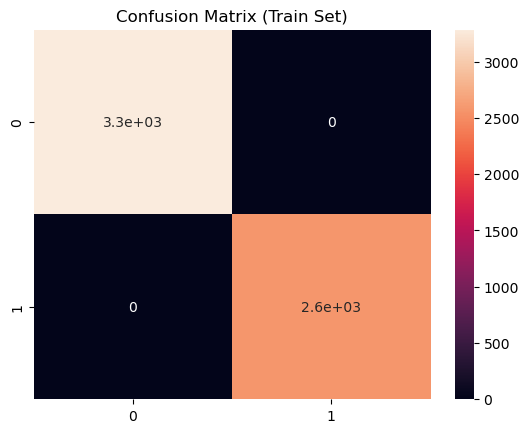

In [154]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Dataset2/train/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Dataset2/train/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/train/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/train/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

X_test = dataset
y_test = label
X_test = X_test/255.
y_test = to_categorical(y_test)

y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix (Train Set)')

46/46 [==============================] - 5s 100ms/step


Text(0.5, 1.0, 'Confusion Matrix (Val Set)')

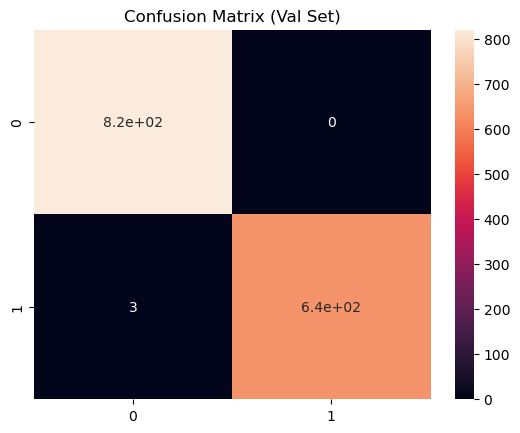

In [155]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Dataset2/val/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Dataset2/val/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/val/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/val/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

X_test = dataset
y_test = label
X_test = X_test/255.
y_test = to_categorical(y_test)

y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix (Val Set)')

In [156]:
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
f1_score = 2 * precision * recall / (precision + recall)

print("Precision on val set:", precision)
print("Recall on val set:", recall)
print("F1 Score on val set:", f1_score)

Precision on val set: 1.0
Recall on val set: 0.9953416149068323
F1 Score on val set: 0.9976653696498053


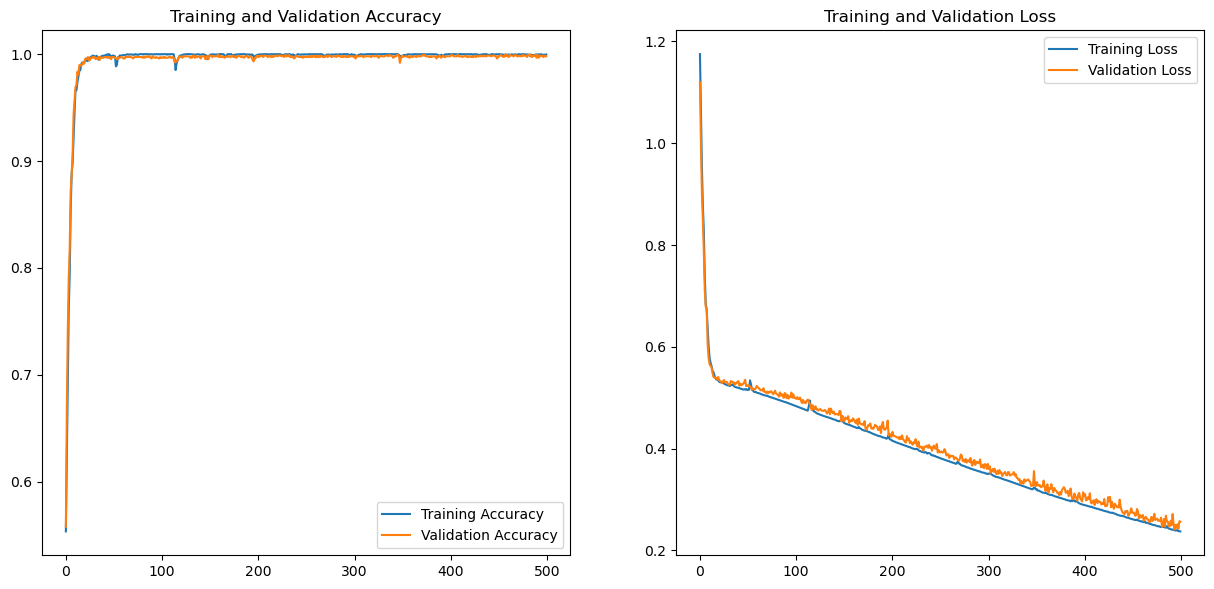

In [157]:
acc = history_bayes.history['accuracy']
val_acc = history_bayes.history['val_accuracy']
loss = history_bayes.history['loss']
val_loss = history_bayes.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The final train value of J is  0.23716787993907928


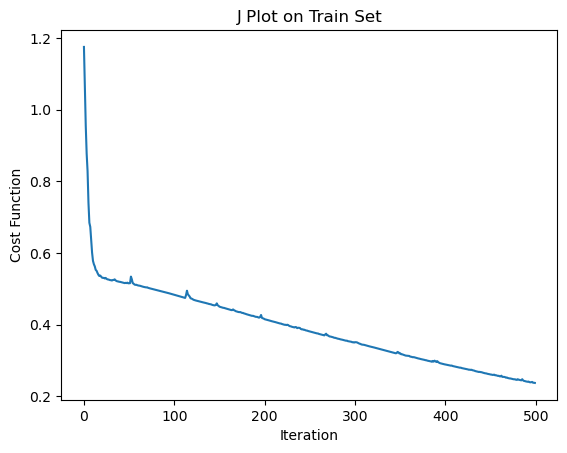

In [158]:
J = history_bayes.history['loss']
plt.plot(J)
plt.title('J Plot on Train Set')
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
print('The final train value of J is ', J[500-1])

The final train value of J is  0.25629082322120667


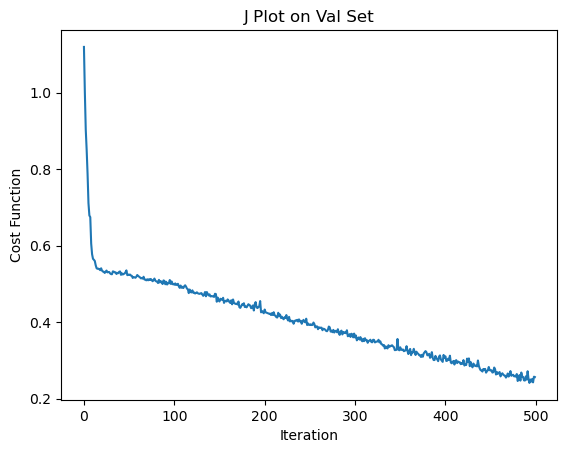

In [160]:
J = history_bayes.history['val_loss']
plt.plot(J)
plt.title('J Plot on Val Set')
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
print('The final train value of J is ', J[500-1])

### Predict

In [205]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Prediction/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Prediction/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Prediction/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Prediction/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [206]:
X_test = dataset
y_test = label

In [207]:
X_test = X_test/255.
y_test = to_categorical(y_test)

In [208]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.6,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.6,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_test)

79/79 [==============================] - 27s 341ms/step


Text(0.5, 1.0, 'Confusion matrix (Test Set)')

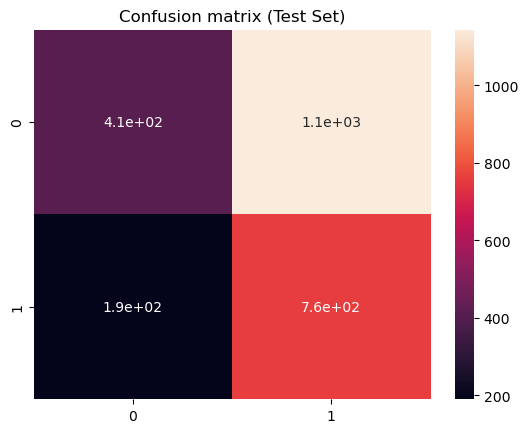

In [209]:
y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix (Test Set)')

In [210]:
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
f1_score = 2 * precision * recall / (precision + recall)

print("Precision on test set:", precision)
print("Recall on test set:", recall)
print("F1 Score on test set:", f1_score)

Precision on test set: 0.39915966386554624
Recall on test set: 0.8
F1 Score on test set: 0.5325858444288717


## Save Model

In [211]:
model_bayes.save("bayesian_model")
model = tf.saved_model.load("bayesian_model")

INFO:tensorflow:Assets written to: bayesian_model\assets


INFO:tensorflow:Assets written to: bayesian_model\assets


## Load Saved Model

In [2]:
loaded_model = tf.keras.models.load_model("bayesian_model", compile=False)
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_3  (None, 217, 217, 4)      1544      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 108, 108, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 51, 64)        18496     
                                                      

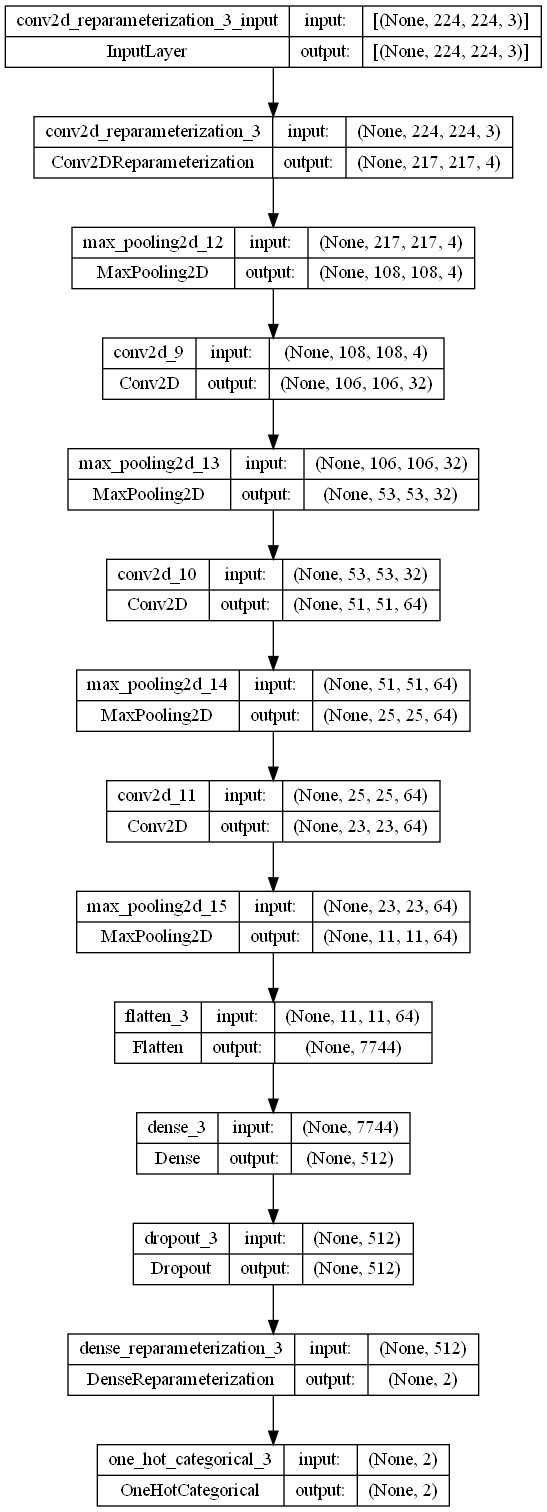

In [213]:
plot_model(loaded_model, to_file='bayesian_model_plot.png', show_shapes=True, show_layer_names=True)

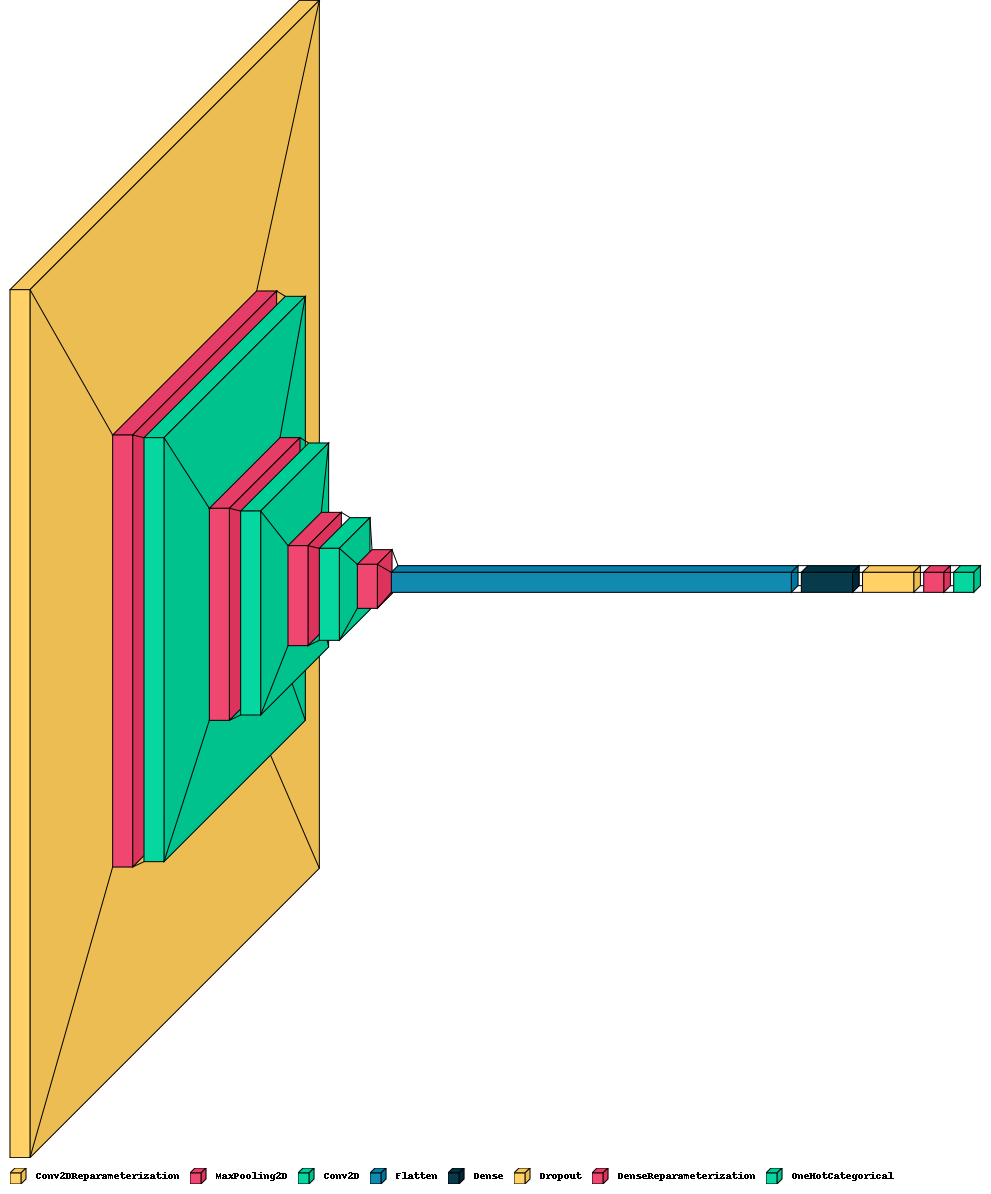

In [214]:
visualkeras.layered_view(loaded_model, legend=True) 

## Detect Anormalies

In [134]:
# stroke_image_list = []
# stroke_images = os.listdir('Dataset2/val/Stroke/')
# for i, image_name in enumerate(stroke_images):
#     image = cv2.imread('Dataset2/val/Stroke/' + image_name)
#     image = Image.fromarray(image)
#     image = image.resize((size,size))
#     stroke_image_list.append(np.array(image))

# pneumothorax_images_idx = np.where(y_pred == 1)[0]
# predicted_as_para = []
# for i in pneumothorax_images_idx:
#     pneu_img = X_test[i]
#     predicted_as_para.append(pneu_img)
    
# predicted_as_para = np.array(predicted_as_para)

In [25]:
# def plot_heatmap(img, model):
#     pred = model.predict(np.expand_dims(img, axis=0))
#     pred_class = np.argmax(pred)
#     last_layer_weights = model.layers[-1].get_weights()[0]
#     last_layer_weights_for_pred = last_layer_weights[:, pred_class]
#     last_conv_model = Model(model.input, model.get_layer("max_pooling2d_11").output)
#     last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
#     last_conv_output = np.squeeze(last_conv_output)
    
#     h = int(img.shape[0]/last_conv_output.shape[0])
#     w = int(img.shape[1]/last_conv_output.shape[1])
#     upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
#     heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 64)), 
#                  last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
#     heat_map[img[:,:,0] == 0] = 0 
     
#     peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

#     plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
#     plt.imshow(heat_map, cmap='jet', alpha=0.30)
#     for i in range(0,peak_coords.shape[0]):
#         print(i)
#         y = peak_coords[i,0]
#         x = peak_coords[i,1]
#         plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


In [26]:
# image = random.randint(0,predicted_as_para.shape[0]-1)
# heat_map = plot_heatmap(predicted_as_para[image], model_bayes)

# img = predicted_as_para[image]
# plt.imshow(predicted_as_para[img])

In [4]:
# Load and preprocess the image
img = cv2.imread('Prediction/Stroke/58 (3).jpg')
img = cv2.resize(img, (224, 224)) / 255.0
img = np.expand_dims(img, axis=0)

# Get the predicted class probabilities
probs = loaded_model.predict(img)[0]
print(probs)
# Threshold the probabilities to obtain a binary mask
mask = np.zeros_like(probs)
mask[np.argmax(probs)] = 1

# Extract the bounding box from the binary mask
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    x, y, w, h = cv2.boundingRect(contours[0])
    # Draw the bounding box on the original image
    cv2.rectangle(img[0], (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with the bounding box
cv2.imshow('image', img[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step
[0. 1.]
